In [1]:
import urllib.request
from bs4 import BeautifulSoup as bs
import re
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Page:
    '''
    represents a single wikipedia page
    '''    
    def __init__(self, mySubj, myTier, myStop):
        '''
        constructor for page class
        mySubj is a string representing the desired subject
        '''
        self.tier = myTier # the tier of this page
        self.stop = myStop # which tier to not include
        self.subject = mySubj # every wikipedia page has shape 'en.wikipedia.org/wiki/subject'; the subject variable stores the last segment
        self.subList = [] # stores other page objects that are found on this page
        self.strList = [] # stores strings representing the names of the page objects
        self.scoreList = [] # stores floats representing the relevance of each page in subList to this page        
        if(self.tier < self.stop):
            response = urllib.request.urlopen('https://en.wikipedia.org/wiki/' + self.subject)
            html = response.read()
            soup = bs(html,'lxml')
            for par in soup.find_all('p'):
                for link in par.find_all('a', href=True):
                    url = link.get('href')
                    if(url.startswith('/wiki/')) and (':' not in url):
                        curSubj = '_'
                        if('#' in url):
                            hashLoc = url.find('#')
                            curSubj = url[6:hashLoc]
                        else:
                            curSubj = url[6:]
                        curPage = Page(curSubj, self.tier + 1, self.stop)
                        self.subList.append(curPage)
                        self.strList.append(str(curPage))
        for pg in self.subList:
            self.scoreList.append(self.getScore(pg))
    
    def fillScoreList(self):
        for pg in self.subList:
            self.scoreList.append(self.getScore(pg))
    
    def getScoreList(self):
        return self.scoreList
    
    def getScore(self, aPage):
        '''
        returns a float between 0 and 1 representing the correlation between self and aPage
        @param aPage is another Page object
        
        score is calculated by len(intersection)/ avg(len(self),len(aPage))
        '''
        selfList = self.getStrList()
        aList = aPage.getStrList()
        intersect = len([x for x in selfList if x in aList])
        selfLen = len(selfList)
        otherLen = len(aList)
        score = intersect/((selfLen + otherLen)/2)
        return score        
    
    def getSubList(self):
        return self.subList
    
    def getStrList(self):
        return self.strList
    
    def getTier(self):
        return self.tier
    
    def getStop(self):
        return self.stop
#     def get scoreList():
#         '''
#         getter method for scoreList
#         '''
#         return scoreList
        
    def __str__(self):
        return self.subject

In [54]:
def nextTier(center, g):
    '''
    creates the next layer
    @param center is a Page object
    @param g is a nx graph object
    '''
    tier = center.getTier() # tier of center
    stop = center.getStop()
    pages = center.getSubList() # list of pages
    names = center.getStrList() # list of strings
    scores = center.getScoreList() # list of floats
    if(tier < stop): # check if there's anymore nodes to plot
        for x in range(0, len(names)):
            pg = pages[x]
            pgStr = names[x]
            score = scores[x]
            g.add_node(str(pg), {'tier': pg.getTier()})
            g.add_edge(str(center),str(pg), weight = score * 0.25)
            nextTier(pg, g)  

def createWeb(center, g):
    '''
    creates entire web
    @param center is a Page object of tier 0
    @param g is a nx graph object
    '''
    tier = center.getTier()
    g.add_node(str(center), {'tier': tier}) #center.getTier() should = 0
    nextTier(center, g) 

In [62]:
myPage = Page('mathematics',0,1)
graph = nx.Graph()

In [63]:
createWeb(myPage, graph)

In [64]:
print(graph.number_of_nodes())

310


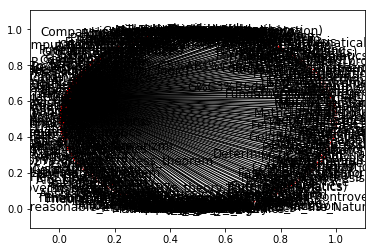

In [66]:
nx.draw_networkx(graph, with_labels = True, node_size = 2, linewidths = 0.2)
fig = plt.gcf()
fig.savefig("graph.pdf")